# Tutorial #3 Learning

this tutorial reproduces the result of the gpp_study repo using the new API of gpp_core

In [1]:
%load_ext autoreload
%autoreload 2

### Definitions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from environments.gridworlds.gridworld import GridWorld
from environments.gridworlds.gridworlds_classic import TwoRooms
from environments.gridworlds.gridactions import *
from agents.pgp.pgp_softmax import SoftMaxPGP
from utils.policy_tools import *

from plots.gridworlds.gridworld_visualizer import GridWorldVisualizer
from plots.agent_plotter import AgentPlotter


In [3]:
maze = TwoRooms(term_locs=np.array([]), actions=IdleActionSet())
agent = SoftMaxPGP(maze)
viz = GridWorldVisualizer(maze, agent)

/home/fran-tr/Workspace/gpp_core/utils/policy_functions.py:43: RuntimeWarning: divide by zero encountered in log
  return np.log(agent.A / np.sum(agent.A, axis=1, keepdims=True))


In [4]:
print("the world is a <{}*{}> grid, it has {} states and {} actions".format(maze.ny, maze.nx, maze.n_state, maze.n_action))
states_rew, _ = maze.get_state_rewards()
print("rewards are located at {}".format(maze.decode(states_rew)))

the world is a <11*23> grid, it has 243 states and 5 actions
rewards are located at [[20  2]]


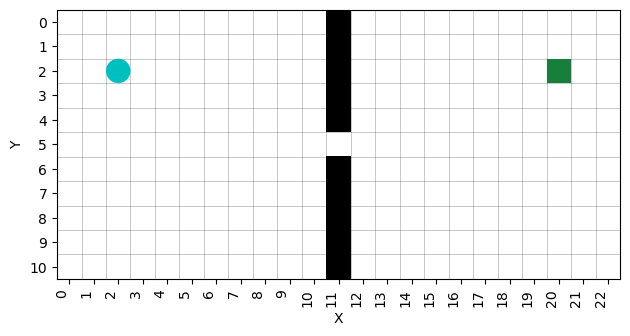

In [5]:
viz.plot_maze()
plt.tight_layout()

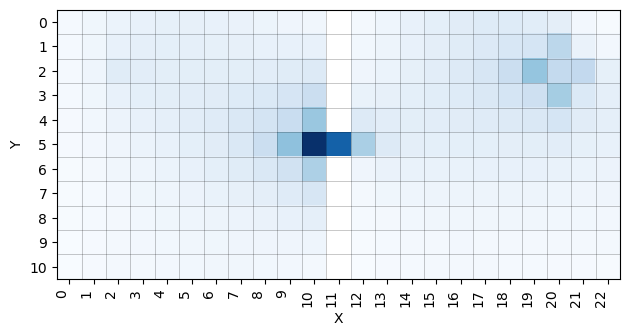

In [6]:
viz.plot_gradient_norm()
plt.tight_layout()

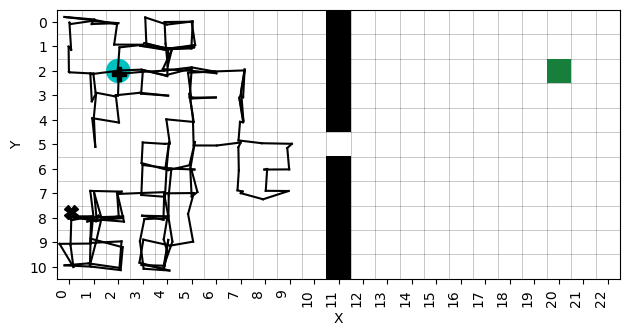

In [7]:
viz.plot_trajectory(n_steps=200)
plt.tight_layout()

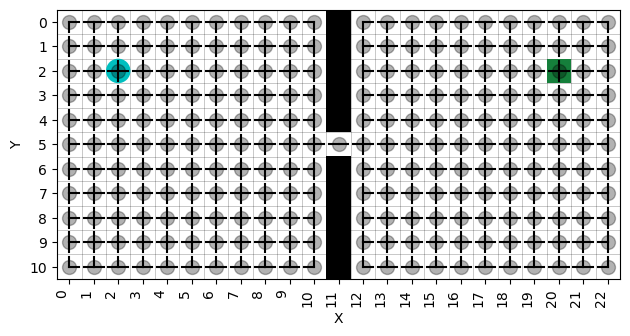

In [8]:
viz.plot_policy()
plt.tight_layout()

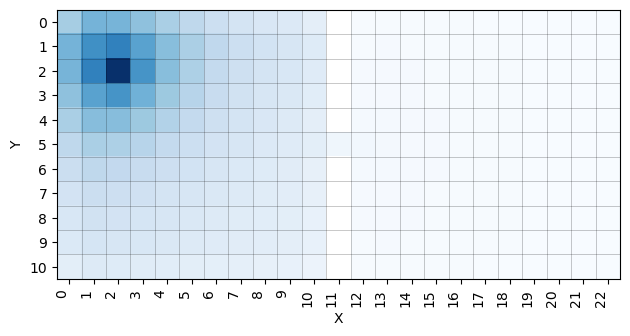

In [9]:
sr = agent.SR
sr_s0 = agent.p0 @ sr

viz.plot_grid(sr_s0)
plt.tight_layout()

## PGP gradient

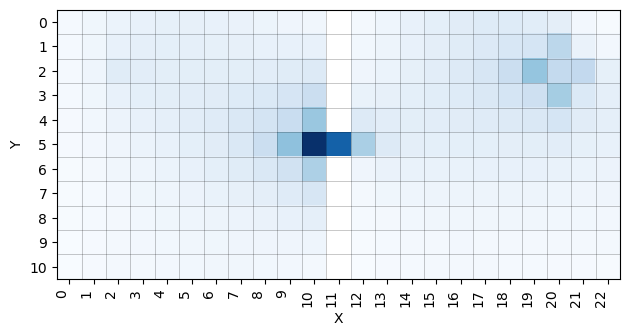

In [10]:
g = agent.gradient()
viz.plot_gradient_norm(grad = g)
plt.tight_layout()

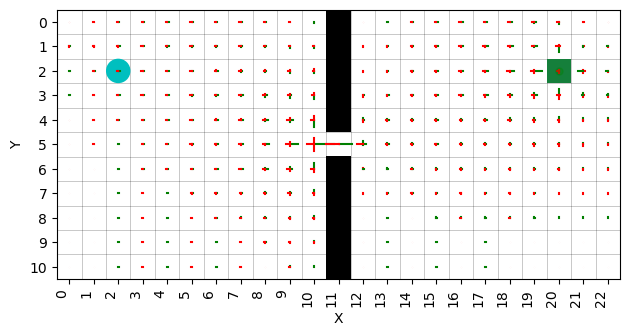

In [11]:
# plot gradient vector field
viz.plot_gradient(factor=2)
plt.tight_layout()

### SR2 as bi directional search

[[20  2]]


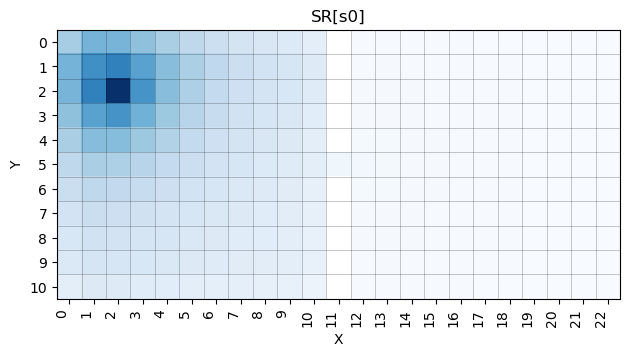

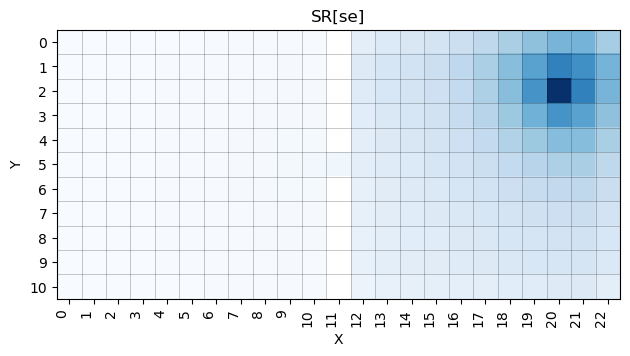

In [12]:
sr_se = sr[states_rew[0]]

print(maze.decode(states_rew))

viz.plot_grid(sr_s0)
plt.tight_layout()
plt.title("SR[s0]")
plt.show()

viz.plot_grid(sr_se)
plt.tight_layout()
plt.title("SR[se]")
plt.show()

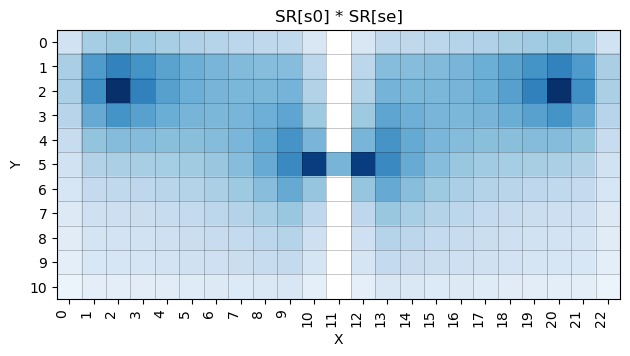

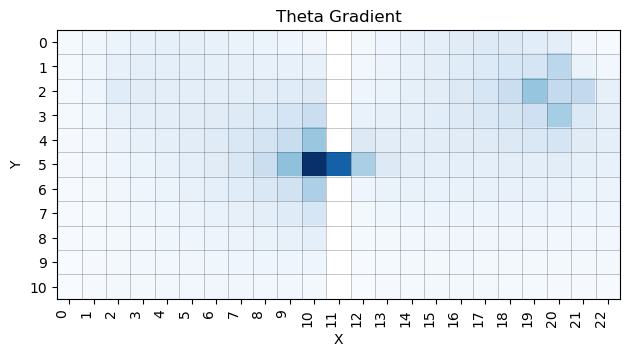

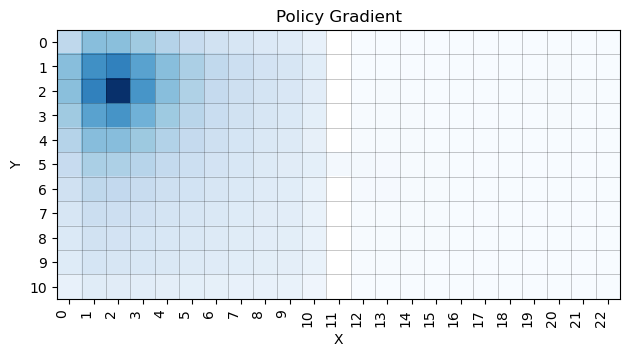

In [13]:

G = agent.gradient()
G_n = np.linalg.norm(G,axis=1)

g_pi = agent.policy_gradient()
g_pi_n = np.linalg.norm(g_pi,axis=1)

viz.plot_grid(sr_s0 * sr_se)
plt.tight_layout()
plt.title("SR[s0] * SR[se]")
plt.show()

viz.plot_grid(G_n)
plt.tight_layout()
plt.title("Theta Gradient")
plt.show()

viz.plot_grid(g_pi_n)
plt.tight_layout()
plt.title("Policy Gradient")
plt.show()

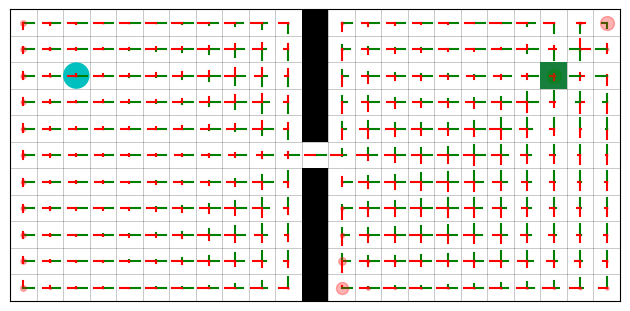

In [14]:
viz.plot_policy(vec=g, factor=1, plot_axis=False)
plt.tight_layout()

two rewards

In [15]:
n = 20
init_locs = np.array([[1, 1]])
term_locs = np.array([])
rew_locs = np.array([[10,12], [3,18]])
rew_vals = np.array([-100.,100.])

maze2 = GridWorld(nx=20,ny=20, init_locs=init_locs, term_locs=term_locs, actions=IdleActionSet())
maze2.add_grid_rewards(rew_vals, rew_locs)
agent2 = SoftMaxPGP(maze2)
viz2 = GridWorldVisualizer(maze2, agent2)

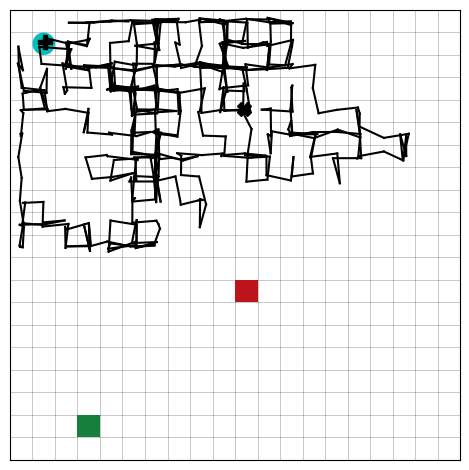

In [16]:
ss, aa, rr, done = agent2.trajectory(n_steps=500)

viz2.plot_trajectory(ss=ss, plot_axis=False)
plt.tight_layout()

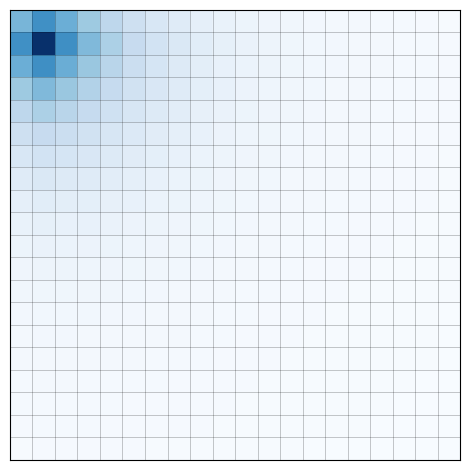

In [17]:
sr2 = agent2.SR
sr20 = agent2.p0 @ sr2
viz2.plot_grid(sr20, plot_axis=False)
plt.tight_layout()

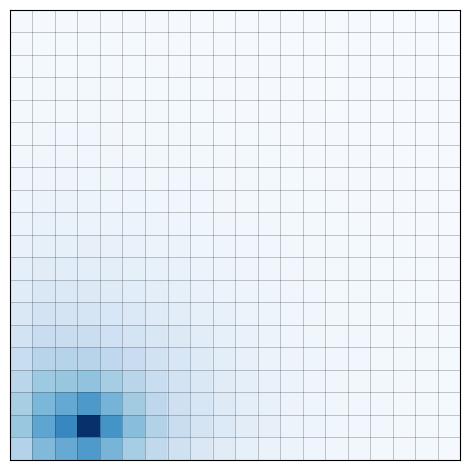

In [18]:
states_rew2, _ = maze2.get_state_rewards()
viz2.plot_grid(sr2[states_rew2[0]], plot_axis=False)
plt.tight_layout()

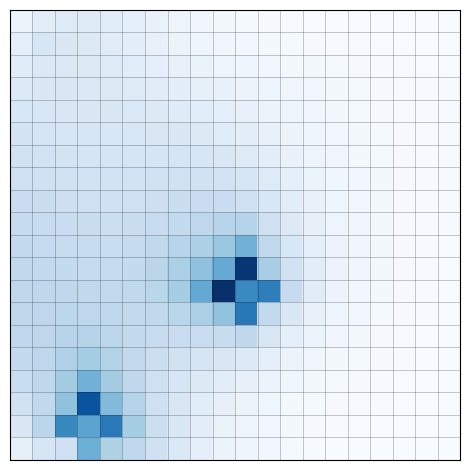

In [19]:
viz2.plot_gradient_norm(plot_axis=False)
plt.tight_layout()

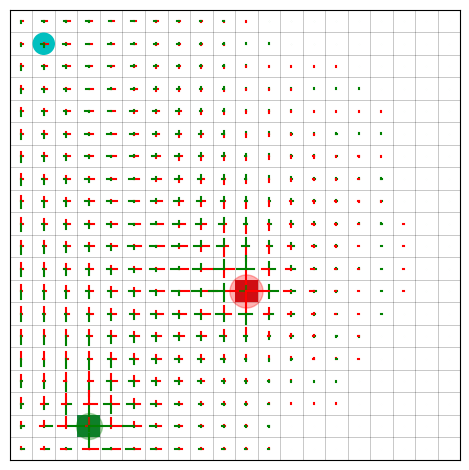

In [20]:
viz2.plot_gradient(factor=3, plot_axis=False)
plt.tight_layout()

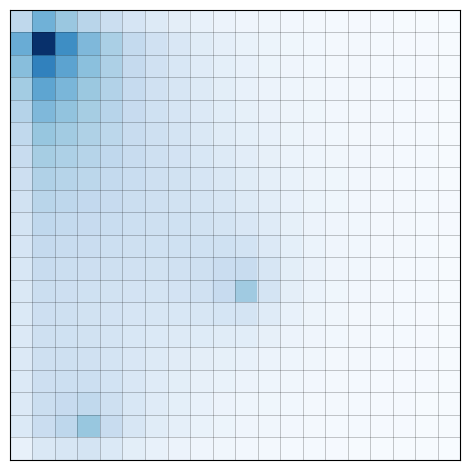

In [21]:
vec = sr2[agent2.state] * np.abs(sr2[states_rew2[0]] + sr2[states_rew2[1]])

viz2.plot_grid(vec, plot_axis=False)
plt.tight_layout()

## GPP learning

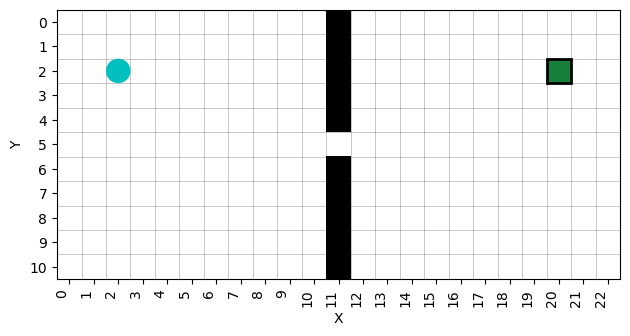

In [22]:
alpha = 0.1
n_steps = 400

maze3 = TwoRooms()
agent3 = SoftMaxPGP(maze3)
viz3 = GridWorldVisualizer(maze3, agent3)

viz3.plot_maze()
plt.tight_layout()

In [23]:
agent3.reset()
agent3.learn(normalize_grad=True, alpha=alpha, n_steps=n_steps)

100%|██████████| 400/400 [00:01<00:00, 307.71it/s]


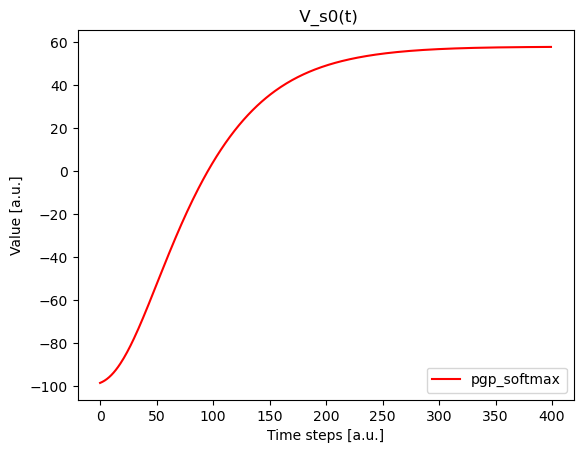

In [24]:
plotter = AgentPlotter([agent3])
plotter.plotValue()

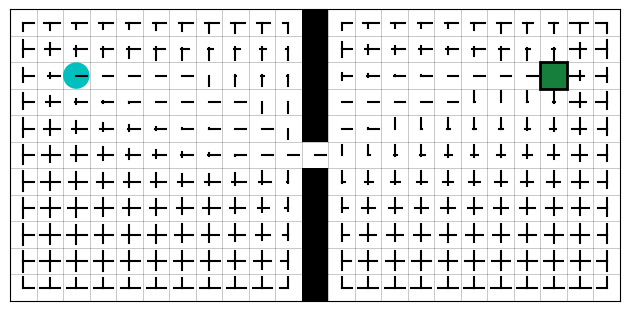

In [25]:
viz3.plot_policy(plot_axis=False)
plt.tight_layout()

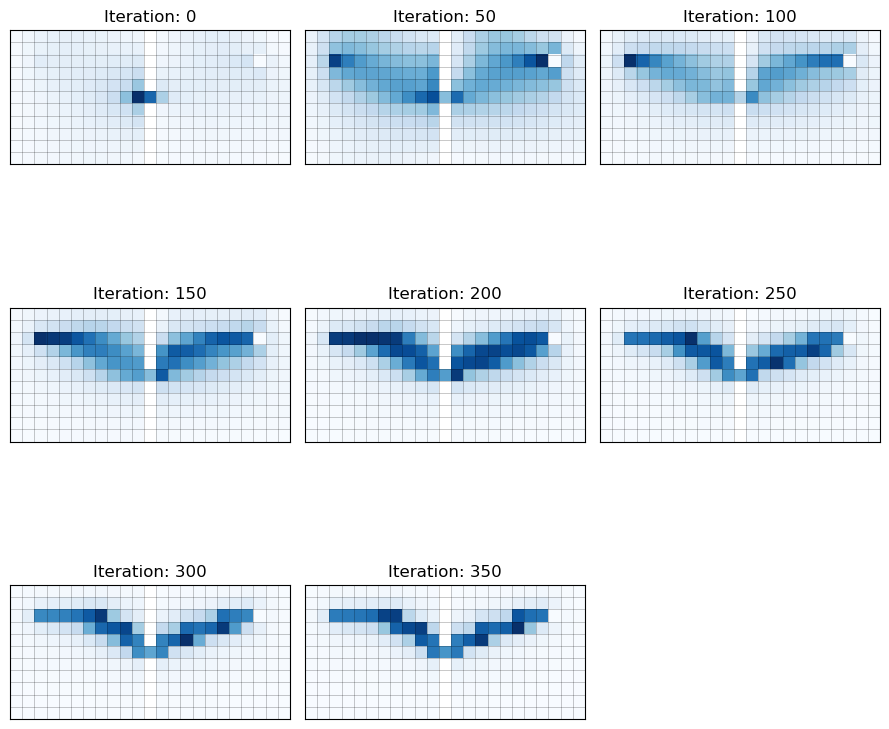

In [31]:
# Load all policies from training
g_t = np.ndarray(agent3.theta_t.shape)
for t in range(g_t.shape[0]):
    agent3.load_history_policy(t)
    g_t[t] = agent3.gradient()

# Put back most recent policy
agent3.load_history_policy()


grad_norms = np.sqrt((g_t**2).sum(axis=2))
grad_norms.shape

idxs = range(0, n_steps,50)

viz3.plot_grids(grad_norms, idxs=idxs, plot_axis=False)
plt.tight_layout()

policy divergence

In [32]:
selected_names =    [   "initial",  "path 1",   "bottleneck",   "path 2",   "final",    "outside"   ]
selected = np.array([   [2, 2],     [6, 3],     [10, 5],        [15, 4],    [20, 2],    [4, 9]      ])
selected_vec = np.array([maze.encode(s) for s in selected])

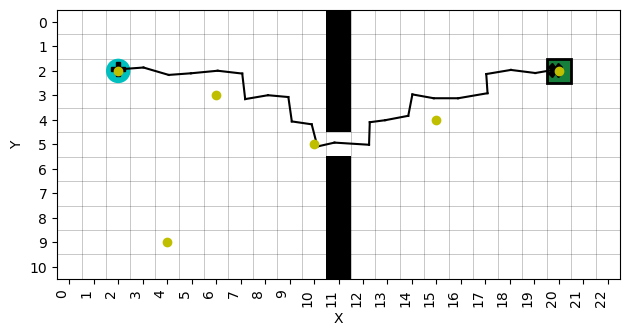

In [33]:
viz3.plot_trajectory(greedy=True)
plt.plot(selected[:,0], selected[:,1], 'yo')
plt.tight_layout()

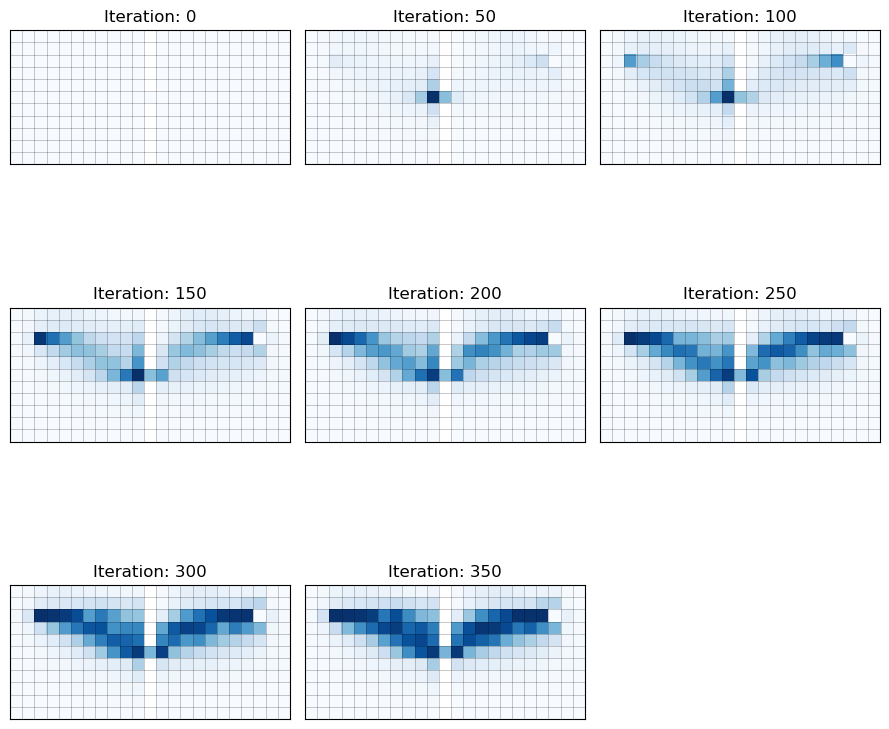

In [34]:
pds = policy_divergence(agent3)

viz3.plot_grids(pds, idxs=idxs, plot_axis=False)
plt.tight_layout()

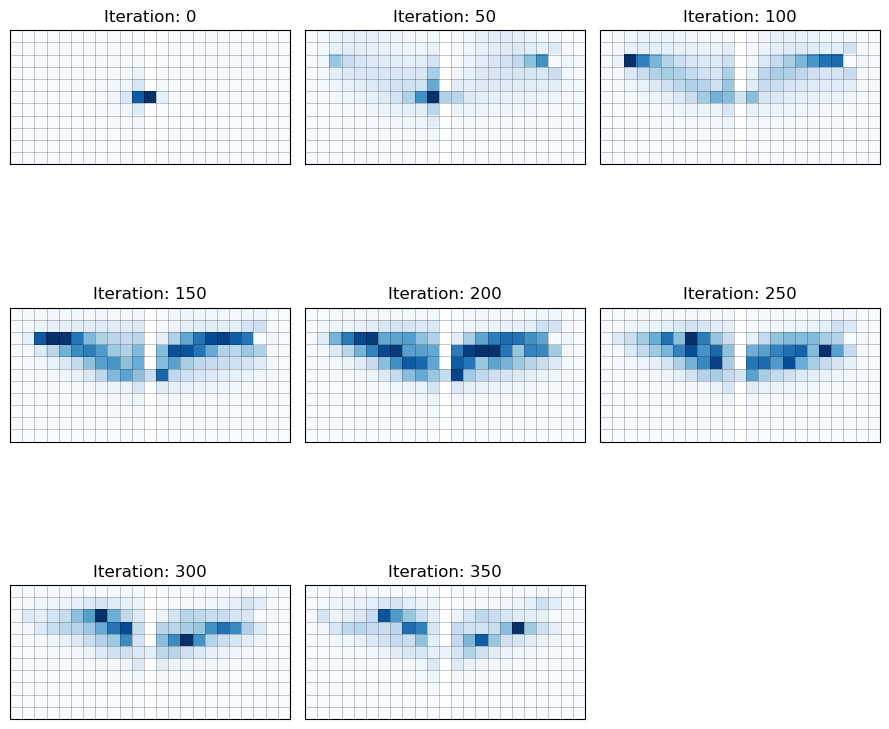

In [35]:
pds_diff = (pds[1:]-pds[:-1])

viz3.plot_grids(pds_diff, idxs=idxs, plot_axis=False)
plt.tight_layout()

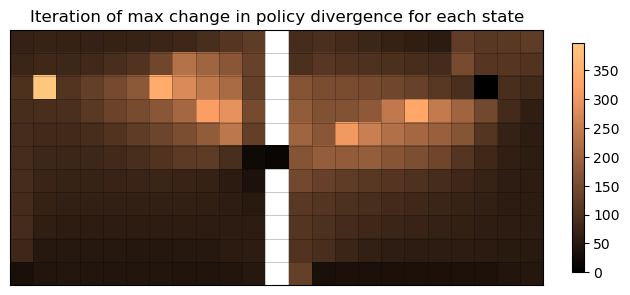

In [36]:
# max derivative iteration for each state
max_iter = np.abs(pds_diff).argmax(axis=0)
viz3.plot_grid(max_iter, cmap='copper', colorbar=True, plot_axis=False)
plt.title('Iteration of max change in policy divergence for each state')
plt.tight_layout()

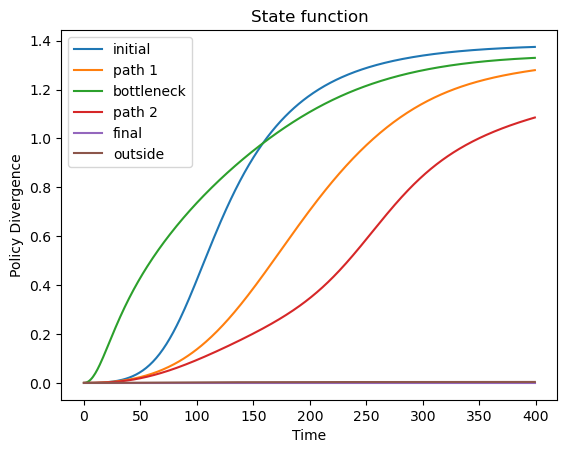

In [37]:
plt.plot(pds[:,selected_vec]);
plt.legend(selected_names);
plt.xlabel('Time');
plt.ylabel('Policy Divergence');
plt.title('State function');
plt.show()

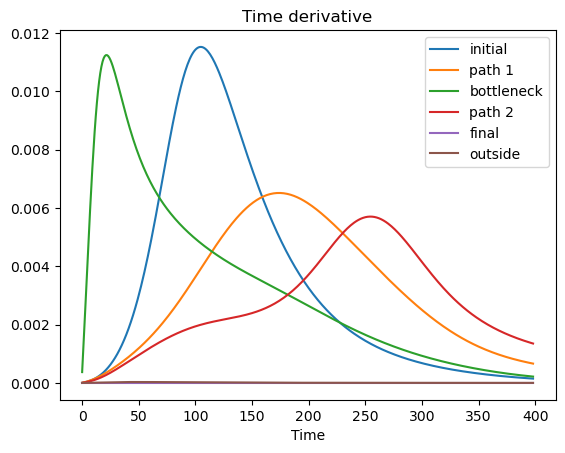

In [38]:
plt.plot(pds_diff[:,selected_vec]);
plt.legend(selected_names);
plt.xlabel('Time');
plt.title("Time derivative");

In [39]:
agent3.theta[maze.states_start]

array([[-3.44652882,  4.7479538 , -3.13111417, -3.71548825]])

In [40]:
max_iter[selected_vec]

array([105, 174,  21, 254,   0,  49])

In [41]:
max_iter[selected_vec].astype(float),agent3.v_t[max_iter[selected_vec]]

(array([105., 174.,  21., 254.,   0.,  49.]),
 array([  8.40772731,  43.50639164, -87.05400376,  54.92808833,
        -98.6469864 , -54.1044681 ]))

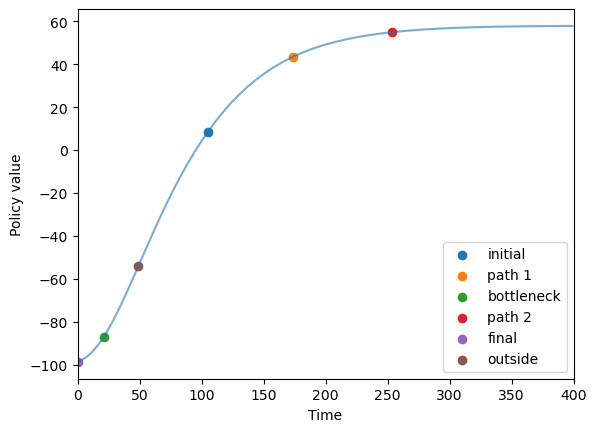

In [42]:
plt.plot(agent3.v_t, alpha=0.6, label='_nolegend_');
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']
for isel, sel in enumerate(selected_vec):
    plt.scatter(max_iter[sel],agent3.v_t[max_iter[sel]],color=cs[isel]);
plt.legend(selected_names)
plt.xlabel('Time');
plt.ylabel('Policy value');
plt.xlim(0, n_steps);

counter differences

In [45]:
agent3.sr0_t.shape

(400, 243)

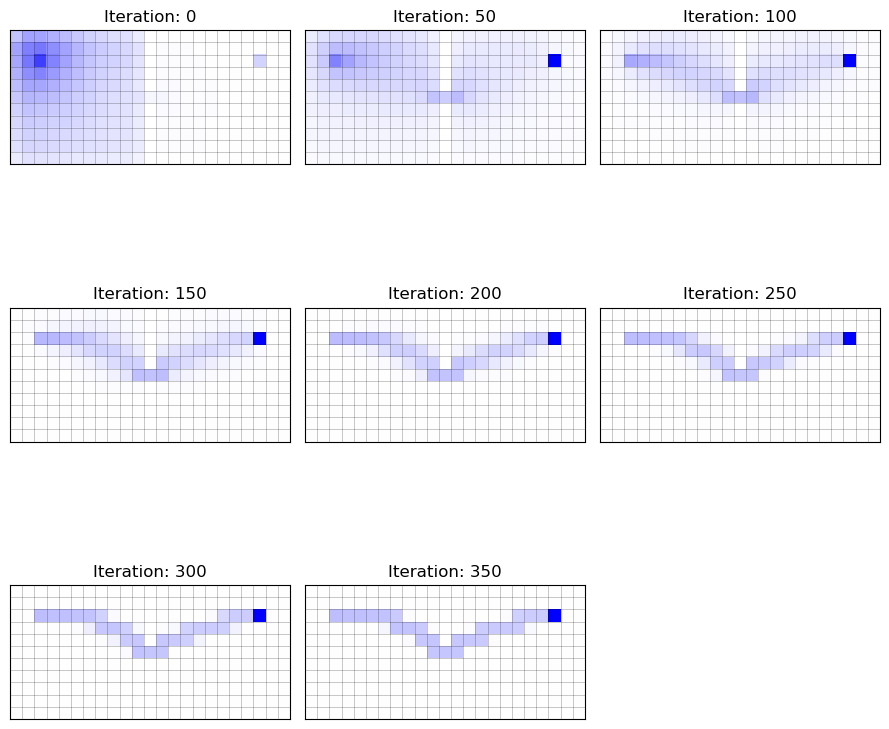

In [52]:
# SRs over time
viz3.plot_grids(agent3.sr0_t, idxs=idxs, cmap='bwr_r', vmin=-4., vmax= 4., colorbar=False, plot_axis=False)
plt.tight_layout()

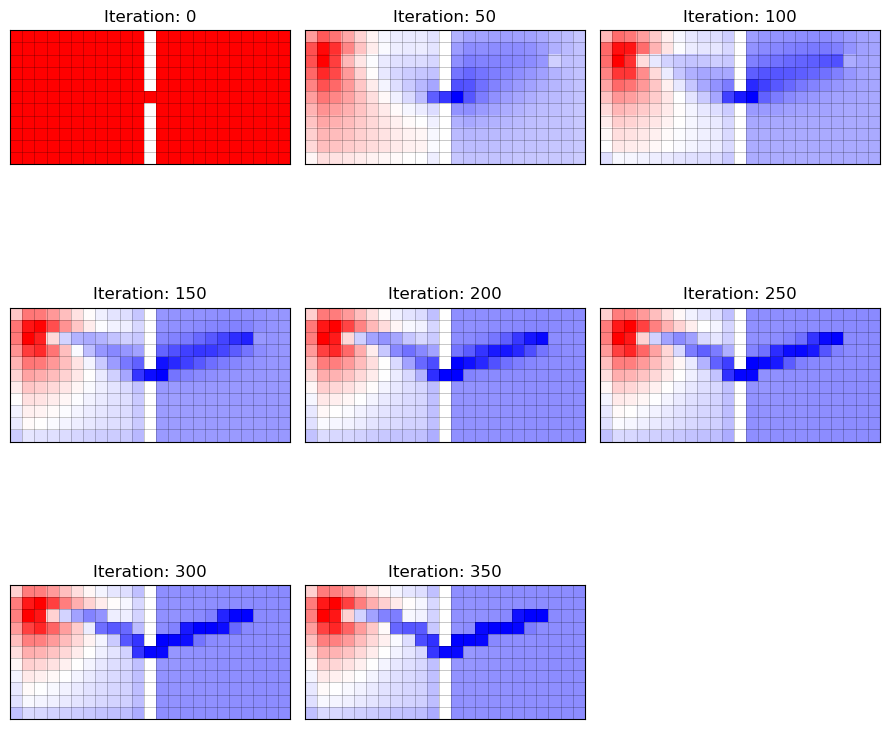

In [53]:
cds = counter_difference(agent3)
cds[:, maze3.states_terminal] = 0

viz3.plot_grids(cds, idxs=idxs, cmap='bwr_r', vmin=None, vmax=None, colorbar=False, plot_axis=False)
plt.tight_layout()


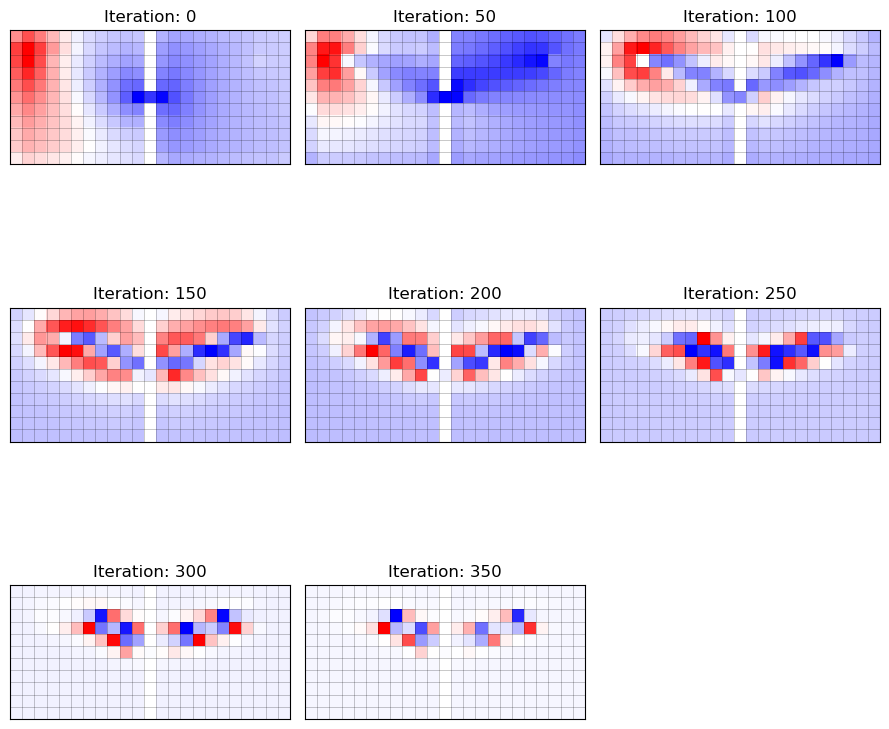

In [54]:
cds_deriv = (cds[1:]-cds[:-1])
viz3.plot_grids(cds_deriv, idxs=idxs, cmap='bwr_r', vmin=None,  vmax=None, colorbar=False, plot_axis=False)
plt.tight_layout()


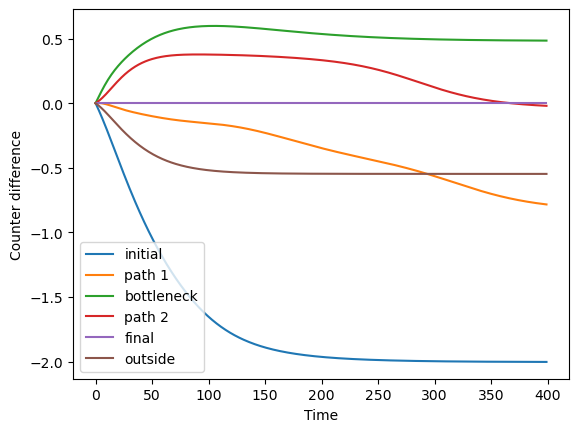

In [55]:
plt.plot(cds[:,selected_vec]);
plt.legend(selected_names);

plt.xlabel('Time');
plt.ylabel('Counter difference');


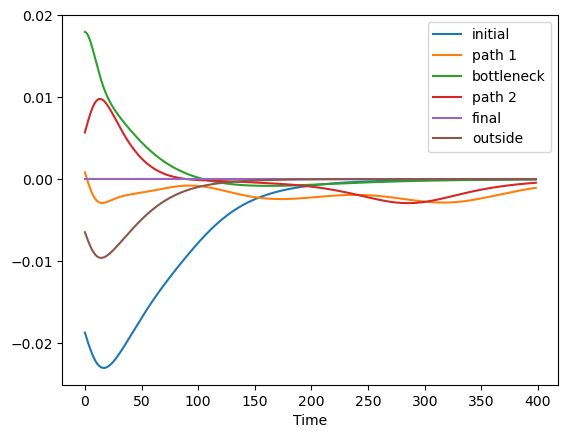

In [56]:
plt.plot(cds_deriv[:,selected_vec]);
plt.legend(selected_names);

plt.xlabel("Time");